In [27]:
# inline plotting instead of popping out
%matplotlib inline

# python 3.7.3
import os, itertools, csv
from joblib import dump, load
from IPython.display import Image
from IPython.display import display

# numpy  1.17.1
import numpy as np

# pandas  0.25.1
import pandas as pd

# scikit-learn  0.21.3
from sklearn.base import clone
# from sklearn.compose import ColumnTransformer
# from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
# from sklearn.feature_selection import SelectFromModel
from sklearn.impute import SimpleImputer 
# from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.svm import SVC

# matplotlib  3.1.1
import matplotlib
matplotlib.rcParams.update({'font.size': 22})
plt = matplotlib.pyplot

# load utility classes/functions that has been taught in previous labs
# e.g., plot_decision_regions()
from lib import *

# Make output directory
if not os.path.exists("output/") : os.mkdir("output/")
if not os.path.exists("models/") : os.mkdir("models/")
if not os.path.exists("cvs/") : os.mkdir("cvs/")

In [28]:
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/'
                 'mushroom/agaricus-lepiota.data', header=None, engine='python')
column_name = ['classes','cap-shape', 'cap-surface','cap-color','bruises?','odor',
               'gill-attachment','gill-spacing','gill-size','gill-color',
               'stalk-shape','stalk-root','stalk-surface-above-ring',
               'stalk-surface-below-ring','stalk-color-above-ring',
               'stalk-color-below-ring','veil-type','veil-color','ring-number',
               'ring-type','spore-print-color','population','habitat']
df.columns = column_name
print(f'Dataset Sahpe: {df.shape}')
df.head()

Dataset Sahpe: (8124, 23)


,classes,cap-shape,cap-surface,cap-color,bruises?,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,stalk-root,stalk-surface-above-ring,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,e,e,s,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,e,c,s,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,e,c,s,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,e,e,s,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,t,e,s,s,w,w,p,w,o,e,n,a,g


# Replace ? with NaN

In [29]:
df = df.replace('?', np.nan)
print(f'The number of rows that is NaN')
display(df.isnull().sum())
print(f'Dataset size: {df.shape}')

The number of rows that is NaN


classes                        0
cap-shape                      0
cap-surface                    0
cap-color                      0
bruises?                       0
odor                           0
gill-attachment                0
gill-spacing                   0
gill-size                      0
gill-color                     0
stalk-shape                    0
stalk-root                  2480
stalk-surface-above-ring       0
stalk-surface-below-ring       0
stalk-color-above-ring         0
stalk-color-below-ring         0
veil-type                      0
veil-color                     0
ring-number                    0
ring-type                      0
spore-print-color              0
population                     0
habitat                        0
dtype: int64

Dataset size: (8124, 23)


In [30]:
parallel_procs = -1

# Feature Importance after Drop NaN Rows / Replace with Most Frequent

Compare the importance of dropping NaNs and replacing with most frequent.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


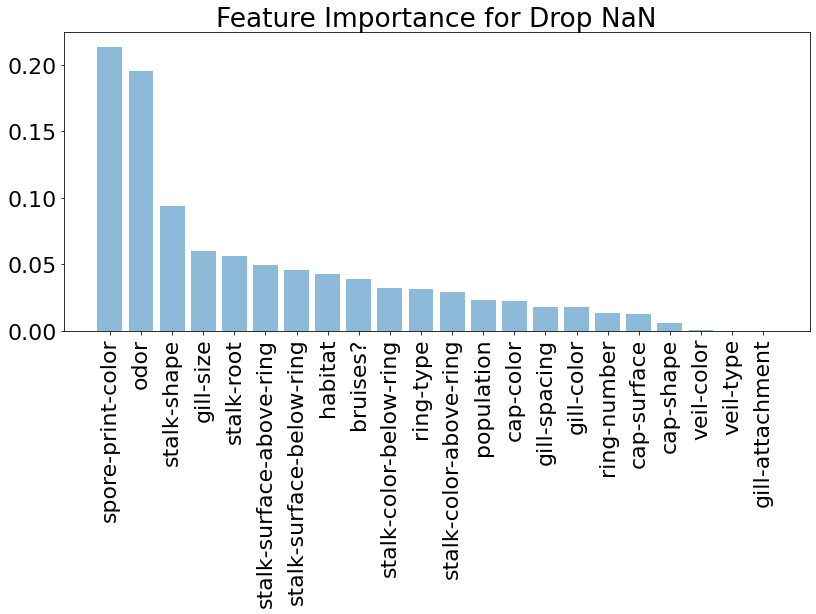

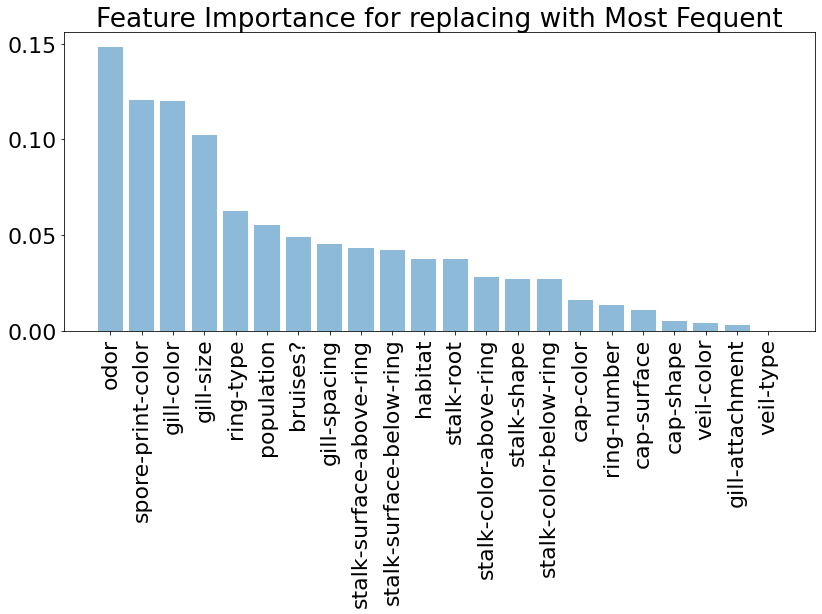

In [31]:
def label_trans(df):
  df_r = df
  le = LabelEncoder()
  for col in df.columns.values:
    df_r[col] = le.fit_transform(df[col])
  return df_r

# pd.DataFrame, np.array
def plot_rf_impo(X, y, title):
  rf = RandomForestClassifier(n_estimators=200, criterion='entropy', n_jobs=parallel_procs)
  rf.fit(X.values, y)
  _, ax = plt.subplots(figsize=(12, 9))
  indice_f = np.argsort(rf.feature_importances_)[::-1]

  plt.title(title)
  ax.bar(range(rf.feature_importances_.shape[0]), 
          rf.feature_importances_[indice_f],
          align='center',
          alpha=0.5)
  plt.xticks(range(rf.feature_importances_.shape[0]),
            X.columns.values[indice_f],
            rotation=90)
  plt.tight_layout()
  plt.show()

  # X_train, X_test, y_train, y_test = train_test_split(X.values, y, test_size=0.2, random_state=42)
  # rf = RandomForestClassifier(n_estimators=200, criterion='entropy', n_jobs=parallel_procs)
  # rf.fit(X_train, y_train)
  # acc = accuracy_score(y_test, rf.predict(X_test))
  # print(f'{acc}')
  # print(f'{np.mean(rf.predict(X_test) == y_test)}')

# drop NaN
df_dropna = df.dropna()
df_dropna = label_trans(df_dropna)
plot_rf_impo(df_dropna.drop(columns=['classes']), df_dropna['classes'].values.ravel(), 'Feature Importance for Drop NaN')

# replace with most frequent
imr = SimpleImputer(missing_values = np.NaN, strategy = 'most_frequent')
df_rep_freq = pd.DataFrame(imr.fit_transform(df), columns=df.columns)
df_rep_freq = label_trans(df_rep_freq)
plot_rf_impo(df_rep_freq.drop(columns=['classes']), df_rep_freq['classes'].values.ravel(), 'Feature Importance for replacing with Most Fequent')

# Select Droping NaN to  Preprocess the Data

In [32]:
df = df_dropna

In [33]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['classes']).values, df['classes'].values, test_size=0.2)
X_train = pd.DataFrame(X_train, columns=df.drop(columns=['classes']).columns)
X_test = pd.DataFrame(X_test, columns=df.drop(columns=['classes']).columns)
y_train = pd.DataFrame(y_train, columns=['classes'])
y_test = pd.DataFrame(y_test, columns=['classes'])

print(f'X_train size: {X_train.shape}')
display(X_train.iloc[:5])
print(f'X_test size: {X_test.shape}')
display(X_test.iloc[:5])
print(f'y_train size: {y_train.shape}')
display(y_train.iloc[:5])
print(f'y_test size: {y_test.shape}')
display(y_test.iloc[:5])

X_train size: (4515, 22)


,cap-shape,cap-surface,cap-color,bruises?,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,stalk-root,stalk-surface-above-ring,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,5,2,4,0,5,1,0,0,7,0,0,3,3,3,3,0,0,2,3,5,5,0
1,2,0,7,0,2,1,0,0,1,0,0,1,1,3,3,0,0,1,1,0,5,4
2,5,0,5,0,1,1,1,1,6,0,0,2,2,5,5,0,0,1,3,2,3,0
3,2,3,4,1,5,1,0,0,6,1,0,2,2,2,2,0,0,1,3,2,4,0
4,5,3,3,0,2,1,0,0,0,0,0,1,1,0,0,0,0,1,1,0,4,0


X_test size: (1129, 22)


,cap-shape,cap-surface,cap-color,bruises?,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,stalk-root,stalk-surface-above-ring,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,2,0,3,1,5,1,0,0,4,1,0,2,2,5,2,0,0,1,3,1,4,0
1,2,2,6,0,5,1,1,0,4,1,2,2,2,5,5,0,0,1,0,2,3,1
2,5,3,6,1,3,1,0,0,2,0,1,2,2,5,5,0,0,1,3,2,2,1
3,2,3,2,1,5,1,0,0,6,1,0,2,2,2,5,0,0,1,3,1,4,0
4,2,3,3,0,2,1,0,0,0,0,0,1,1,4,0,0,0,1,1,0,5,1


y_train size: (4515, 1)


,classes
0,0
1,1
2,1
3,0
4,1


y_test size: (1129, 1)


,classes
0,0
1,0
2,0
3,0
4,1


# Utility Functions of Fine-Tune 

In [35]:
def run_test(pipe, X_train, X_test, y_train, y_test):
  pipe.fit(X_train.values, y_train.values.ravel())
  y_pred = pipe.predict(X_test.values)
  acc = accuracy_score(y_test.values.ravel(), y_pred)
  print(f'Test Accuracy: {acc}')

  return pipe

load_saved = False

global_best_score = 0
global_best_model = None
global_best_cv_results = None
global_best_model_name = 'None'

def grid_tune(clf, params, name, scoring=None, is_show=True):
    if(not load_saved):
        gs = GridSearchCV(clf, params, scoring=scoring, cv=5, n_jobs=parallel_procs, return_train_score=True)
        gs.fit(X_train.values, y_train.values.ravel())

        cv_results = pd.DataFrame(gs.cv_results_)
        best_score = gs.best_score_
        best_param = gs.best_params_
        best_model = clone(gs.best_estimator_)
        best_model.fit(X_train.values, y_train.values.ravel())
    else:
        best_model = load(f'models/{name}.joblib')
        cv_results = pd.read_csv(f'cvs/{name}-cv.csv', index_col=False)
        cv_results.drop(cv_results.columns[[0]], axis=1, inplace=True)
        best_param = best_model.get_params()
        
        score_sorted_idxs = np.argsort(cv_results[['mean_test_score']].values.ravel())[::-1]
#         print(score_sorted_idxs)
#         print(score_sorted_idxs[0])
        best_score = cv_results.loc[score_sorted_idxs[0], ['mean_test_score']].values[0]
        
    if(is_show):
        display(cv_results.drop(columns=['mean_fit_time',	
                                         'std_fit_time',	
                                         'mean_score_time',	
                                         'std_score_time',
                                         'split0_train_score', 
                                         'split1_train_score', 
                                         'split2_train_score', 
                                         'split3_train_score', 
                                         'split4_train_score']))
        print(f'Mean Validation Score of Best: {best_score}')
        print(f'Params of Best: {best_param}')
    
    return best_model, best_score, best_param, cv_results

def record(model, score, cv_results, name):
    print(f'Recording Model: {name}')
    global global_best_score
    global global_best_model
    global global_best_cv_results
    global global_best_model_name
    
    if(global_best_model == None and global_best_score == 0):
        print(f'Init Best Model: {name}, CV: {score}')
        global_best_score = score
        global_best_model = model
        global_best_cv_results = cv_results
        global_best_model_name = name
        
        dump(model, f'models/{name}.joblib')
        dump(model, f'models/best.joblib')
        cv_results.to_csv('cvs/best-cv.csv')
        cv_results.to_csv(f'cvs/{name}-cv.csv')
        
    else:
        if(global_best_score > score):
            print(f'Keep Best Model: {global_best_model_name}, CV: {global_best_score}')
            dump(model, f'models/{name}.joblib')
            cv_results.to_csv(f'cvs/{name}-cv.csv')
            
        else:
            print(f'Update Best Model: {name}, CV: {score}')
            global_best_score = score
            global_best_model = model
            global_best_cv_results = cv_results
            global_best_model_name = name
            
            dump(model, f'models/{name}.joblib')
            dump(model, f'models/best.joblib')
            cv_results.to_csv('cvs/best-cv.csv')
            cv_results.to_csv(f'cvs/{name}-cv.csv')

# Pair: (name, model, params)
def model_search(model_param_list):
    for pair in model_param_list:
        model, score, param = grid_tune(pair[1], pair[2])
        record(model, score, pair[0])
        
    best_predict()
        
def best_predict():
    best = load('models/best.joblib')
    print(f'Best Model')
    print(f'{type(best).__name__}')
    print(f'Parameters')
    print(best.get_params())
    print(f'Training Acc')
    print(f'{accuracy_score(y_train, best.predict(X_train.values))}')
    print(f'CV 5 folds Acc')
    cv_score = cross_val_score(clone(best), X_train.values, y_train.values.ravel(), cv=5)
    print(f'Mean {sum(cv_score) / len(cv_score)}')
    print(f'{cv_score}')
    
    pred_best = pd.DataFrame(best.predict(X_test))
    pred_best.to_csv('models/best.csv', index=False, header=False)
    
    return pred_best

# KNN

In [36]:
params = [{
              'n_neighbors': [5, 100, 200, 500, 1000],
              'weights': ['distance'],
              'metric': ['minkowski', 'euclidean', 'manhattan', 'chebyshev', 'mahalanobis', 'seuclidean', 'mahalanobis'],
              'n_jobs': [parallel_procs]
         }]

model, score, param, cv_results = grid_tune(KNeighborsClassifier(), params, 'knn')
record(model, score, cv_results, 'knn')

,param_metric,param_n_jobs,param_n_neighbors,param_weights,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,mean_train_score,std_train_score
0,minkowski,-1,5,distance,"{'metric': 'minkowski', 'n_jobs': -1, 'n_neigh...",1.000000,1.000000,1.000000,0.997785,1.000000,0.999557,0.000886,2,1.0,0.0
1,minkowski,-1,100,distance,"{'metric': 'minkowski', 'n_jobs': -1, 'n_neigh...",0.976744,0.972315,0.970100,0.975637,0.974529,0.973865,0.002385,6,1.0,0.0
2,minkowski,-1,200,distance,"{'metric': 'minkowski', 'n_jobs': -1, 'n_neigh...",0.956811,0.949059,0.945736,0.950166,0.953488,0.951052,0.003798,10,1.0,0.0
3,minkowski,-1,500,distance,"{'metric': 'minkowski', 'n_jobs': -1, 'n_neigh...",0.911406,0.902547,0.928018,0.908084,0.895903,0.909192,0.010782,12,1.0,0.0
4,minkowski,-1,1000,distance,"{'metric': 'minkowski', 'n_jobs': -1, 'n_neigh...",0.862680,0.853821,0.879291,0.864895,0.861573,0.864452,0.008305,16,1.0,0.0
5,euclidean,-1,5,distance,"{'metric': 'euclidean', 'n_jobs': -1, 'n_neigh...",1.000000,1.000000,1.000000,0.997785,1.000000,0.999557,0.000886,2,1.0,0.0
6,euclidean,-1,100,distance,"{'metric': 'euclidean', 'n_jobs': -1, 'n_neigh...",0.976744,0.972315,0.970100,0.975637,0.974529,0.973865,0.002385,6,1.0,0.0
7,euclidean,-1,200,distance,"{'metric': 'euclidean', 'n_jobs': -1, 'n_neigh...",0.956811,0.949059,0.945736,0.950166,0.953488,0.951052,0.003798,10,1.0,0.0
8,euclidean,-1,500,distance,"{'metric': 'euclidean', 'n_jobs': -1, 'n_neigh...",0.911406,0.902547,0.928018,0.908084,0.895903,0.909192,0.010782,12,1.0,0.0
9,euclidean,-1,1000,distance,"{'metric': 'euclidean', 'n_jobs': -1, 'n_neigh...",0.862680,0.853821,0.879291,0.864895,0.861573,0.864452,0.008305,16,1.0,0.0


Mean Validation Score of Best: 1.0
Params of Best: {'metric': 'manhattan', 'n_jobs': -1, 'n_neighbors': 5, 'weights': 'distance'}
Recording Model: knn
Init Best Model: knn, CV: 1.0


# SVC

In [37]:
params = [{
              'C': [1, 5, 10], 
              'kernel': ['rbf', 'sigmoid'], 
          },
          {
              'C': [1, 5, 10], 
              'kernel': ['poly'],
              'degree': [3, 5, 7]
          }]

model, score, param, cv_results = grid_tune(SVC(), params, 'svc')
record(model, score, cv_results, 'svc')

,param_C,param_kernel,param_degree,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,mean_train_score,std_train_score
0,1,rbf,NaN,"{'C': 1, 'kernel': 'rbf'}",0.998893,0.995570,0.996678,1.000000,0.998893,0.998007,0.001628,12,0.998228,0.000513
1,1,sigmoid,NaN,"{'C': 1, 'kernel': 'sigmoid'}",0.799557,0.792913,0.812846,0.795127,0.588040,0.757697,0.085110,13,0.757364,0.094434
2,5,rbf,NaN,"{'C': 5, 'kernel': 'rbf'}",1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1,1.000000,0.000000
3,5,sigmoid,NaN,"{'C': 5, 'kernel': 'sigmoid'}",0.782946,0.777409,0.789590,0.789590,0.583610,0.744629,0.080638,14,0.741085,0.087667
4,10,rbf,NaN,"{'C': 10, 'kernel': 'rbf'}",1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1,1.000000,0.000000
5,10,sigmoid,NaN,"{'C': 10, 'kernel': 'sigmoid'}",0.782946,0.775194,0.789590,0.790698,0.582503,0.744186,0.081031,15,0.739313,0.087741
6,1,poly,3,"{'C': 1, 'degree': 3, 'kernel': 'poly'}",1.000000,0.998893,0.998893,1.000000,1.000000,0.999557,0.000543,11,0.999612,0.000136
7,1,poly,5,"{'C': 1, 'degree': 5, 'kernel': 'poly'}",1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1,1.000000,0.000000
8,1,poly,7,"{'C': 1, 'degree': 7, 'kernel': 'poly'}",1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1,1.000000,0.000000
9,5,poly,3,"{'C': 5, 'degree': 3, 'kernel': 'poly'}",1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1,1.000000,0.000000


Mean Validation Score of Best: 1.0
Params of Best: {'C': 5, 'kernel': 'rbf'}
Recording Model: svc
Update Best Model: svc, CV: 1.0


# Select The Best Model

Finally, it chooses SVC as the best model.

In [38]:
pred_best = best_predict()
acc = accuracy_score(y_test, pred_best)

print(f"\nTest Acc: {acc}")

Best Model
SVC
Parameters
{'C': 5, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'scale', 'kernel': 'rbf', 'max_iter': -1, 'probability': False, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}
Training Acc
1.0
CV 5 folds Acc
Mean 1.0
[1. 1. 1. 1. 1.]

Test Acc: 1.0
